# iSCAT Analysis Demo

This notebook demonstrates:

**Simulation**
* Simulating multiple tracks with different diffusion models

**Analysis**
* Loading mulitple tracks from a single file
* Retreiving single tracks from this
* Apparent Diffusion Coefficient (ADC) analysis of a single track
* ADC analysis of multiple tracks at once
* Retreiving analysis results using `adc_summary`
* Retreiving tracks that fit a certain diffusion category

## Simulation with `iscat_lib.simulators`

First, import the required simulators:

In [1]:
from iscat_lib.simulators import BrownianDiffusion
from iscat_lib.simulators import HoppingDiffusion

A simulator can be initialised with different parameters. For Brownian diffusion, this looks as follows:

In [5]:
params = dict()
params["Tmax"] = 1.0 # Maximum simulation time (s)
params["dt"] = 1e-4 # Simulation time resolution (s)
params["dL"] = 1e-12 # Simulation spatial resolution (m)
params["d"] = 1e-12 # Diffusion coefficient (m^2/s)
params["L"] = 1e-5 # Simulation domain size (m)
params["seed"] = 42 # Seed to initialize the random generator (for reproducibility)
params["quantize"] = False # Quantize the position to the simulation spatial resolution grid.

simulator_brownian = BrownianDiffusion(**params)

Other simulators, like hop diffusion, expect different parameters:

In [14]:
params = dict()
params["Tmax"] = 1.0 # Maximum simulation time (s)
params["dt"] = 1e-4 # Simulation time resolution (s)
params["dL"] = 1e-8 # Simulation spatial resolution (m)
params["Df"] = 8e-13 # Free diffusion coefficient [m^2/s]
params["L"] = 1e-5 # Simulation domain size (m)
params["HP"] = 0.01 # Hopping probability [0-1]
params["HL"] = 1e-6 # Average compartment diameter/length [m]
params["seed"] = 42 # Seed to initialize the random generator (for reproducibility)
params["quantize"] = False # Quantize the position to the simulation spatial resolution grid.

simulator_hop = HoppingDiffusion(**params)

After initialisation, the simulations can be run. Results will be stored in the simulator.

In [15]:
simulator_brownian.run()
simulator_hop.run()

Brownian Diffusion Simulation: 100%|██████████| 10000/10000 [00:00<00:00, 168979.35it/s]
Simulation: 10001it [00:00, 116970.76it/s]           


The resulting trajectories can be plotted:

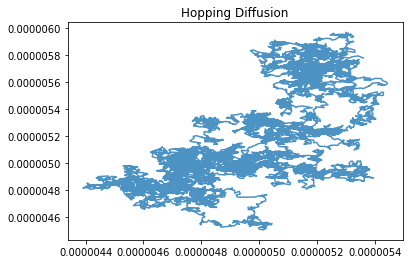

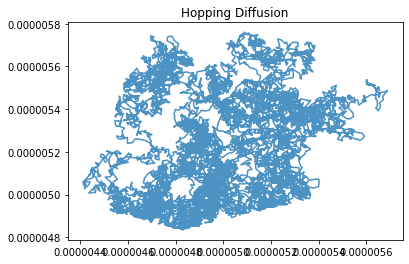

In [16]:
simulator_brownian.display_trajectory()
simulator_hop.display_trajectory()

It is also possible to export the simulated tracks as videos using the `iscat_lib.simulators.iscat_movie` class. Currently, the tracks need first to be saved e.g. as a `.csv` using `BrownianDiffusion.save()` (or any other Diffusion model) and then load them again using `iscat_movie.load_tracks()`. You also need to load a PSF with `iscat_movie.load_psf()`.

Before we start fitting our data, we need to add some models. `iscat_lib.analysis.models` contains a few models that we can add to `ModelDB`. All models added this way will be used during analysis.

## Analysis using `iscat_lib.analysis`

In [17]:
from iscat_lib.analysis import ModelDB
from iscat_lib.analysis.models import ModelBrownian, ModelConfined, ModelHop

ModelDB().add_model(ModelBrownian)
ModelDB().add_model(ModelConfined)
ModelDB().add_model(ModelHop)

Multiple tracks are stored in a `ListOfTracks` objects. 

In [18]:
from iscat_lib.analysis import ListOfTracks

In [25]:
import random
tracks = []
for i in range(10):
    simulator_brownian.run()
    simulator_hop.run()
    tracks.append(Track.from_dict(simulator_brownian.trajectory))
    tracks.append(Track.from_dict(simulator_hop.trajectory))

Brownian Diffusion Simulation: 100%|██████████| 10000/10000 [00:00<00:00, 158938.97it/s]
Simulation: 10001it [00:00, 111313.12it/s]           
Brownian Diffusion Simulation: 100%|██████████| 10000/10000 [00:00<00:00, 178254.22it/s]
Simulation: 10001it [00:00, 111554.67it/s]           
Brownian Diffusion Simulation: 100%|██████████| 10000/10000 [00:00<00:00, 177556.97it/s]
Simulation: 10001it [00:00, 117623.14it/s]           
Brownian Diffusion Simulation: 100%|██████████| 10000/10000 [00:00<00:00, 178548.64it/s]
Simulation: 10001it [00:00, 115618.27it/s]           
Brownian Diffusion Simulation: 100%|██████████| 10000/10000 [00:00<00:00, 179556.83it/s]
Simulation: 10001it [00:00, 118004.33it/s]           
Brownian Diffusion Simulation: 100%|██████████| 10000/10000 [00:00<00:00, 180750.01it/s]
Simulation: 10001it [00:00, 115568.90it/s]           
Brownian Diffusion Simulation: 100%|██████████| 10000/10000 [00:00<00:00, 177796.32it/s]
Simulation: 10001it [00:00, 117361.84it/s]           

Load the tracks from some example data. We can use `tracks.normalize` to set the initial time value of all tracks to 0.

In [26]:
tracks = ListOfTracks(tracks)

Single tracks are stored in a `Track` object.

In [27]:
from iscat_lib.analysis import Track

We can retreive single tracks either by their index in then `LiftOfTracks` object using `get_track` of by their ID (should they have one) using `get_track_by_id`:

In [28]:
single_track = Track.from_dict(simulator_brownian.trajectory)

We can now do ADC analysis on the track:

In [29]:
results = single_track.adc_analysis(fit_max_time=0.5e-1)

Analysis results like the calculated values for $D_{app}$, fit parameters and much more are returned in a dictionary. We can also retreive the dictionary of the last analysis at any time with `get_adc_analysis_results`.

In [30]:
fit_results = results["fit_results"]
best_model = results["best_model"]
print(fit_results)
print(best_model)

{'ModelBrownian': {'params': array([5.19173727e-13, 5.10295841e-09]), 'errors': array([6.12947316e-16, 7.84060463e-11]), 'bic': -57.639471884038, 'rel_likelihood': 0.9809574923846472}, 'ModelConfined': {'params': array([1.21597236e-23, 1.98690109e-08, 3.37709930e-15]), 'errors': array([0.00000000e+00, 1.33810906e-09, 0.00000000e+00]), 'bic': -50.39054451044037, 'rel_likelihood': 0.026155655559820603}, 'ModelHop': {'params': array([5.20389526e-13, 3.08757348e-12, 5.56535491e-11, 2.99687438e-05]), 'errors': array([7.02900314e-16, 2.35003449e-11, 6.33699021e-10, 1.26189174e-04]), 'bic': -57.67792418655417, 'rel_likelihood': 1.0}}
ModelHop


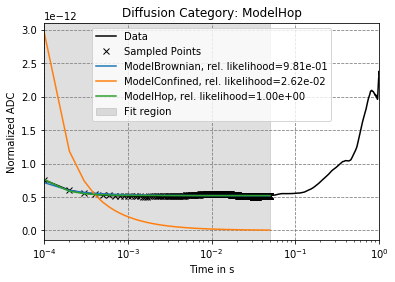

In [31]:
single_track.plot_adc_analysis_results()

In order to set initial parameters or bounds for the fits, we need to modify the models inside `ModelDB`. These will then be applied during all analysis from this point on.

In [32]:
ModelDB().get_model(ModelBrownian).initial = fit_results["ModelBrownian"]["params"]
ModelDB().get_model(ModelConfined).initial = fit_results["ModelConfined"]["params"]
ModelDB().get_model(ModelHop).initial = fit_results["ModelHop"]["params"]

Here, we set all initial parameters to the results of our single fit.

Now that we set our initial guesses, let's analyse the remaining tracks at once.

Enabling logarithmic sampling is a good idea since the time axis will be scaled logarithmically by default. We can also set the maximum time on the time for which to fit.

`adc_analysis` will return a list containing the indices of all tracks for which a fit has failed. These can then be retreived with `get_track` and analysed further.

In [33]:
tracks.adc_analysis(fit_max_time=50e-3, enable_log_sampling=True)

[]

`adc_summary` gives an overview of the analysis results including optional plots, the averaged parameters for each model, the averaged MSD for each model and the averaged $D_{app}$ for each model.

/home/iscat/Desktop/iSCAT_tracking/iscat_lib/analysis/models.py:42: RuntimeWarning: divide by zero encountered in true_divide
  D_micro * (tau/t) * (1 - np.exp(-tau/t)) + \
/home/iscat/Desktop/iSCAT_tracking/iscat_lib/analysis/models.py:43: RuntimeWarning: divide by zero encountered in true_divide
  delta ** 2 / (2 * t * (1 - 2 * self.R * self.dt / t))
/home/iscat/Desktop/iSCAT_tracking/iscat_lib/analysis/models.py:43: RuntimeWarning: invalid value encountered in multiply
  delta ** 2 / (2 * t * (1 - 2 * self.R * self.dt / t))
/home/iscat/Desktop/iSCAT_tracking/iscat_lib/analysis/models.py:20: RuntimeWarning: divide by zero encountered in true_divide
  return D + delta**2 / (2*t*(1-2*self.R*self.dt/t))
/home/iscat/Desktop/iSCAT_tracking/iscat_lib/analysis/models.py:20: RuntimeWarning: invalid value encountered in multiply
  return D + delta**2 / (2*t*(1-2*self.R*self.dt/t))


{'sectors': {'ModelHop': 0.45, 'ModelBrownian': 0.55, 'not catergorized': 0.0},
 'average_params': {'ModelHop': array([6.08331428e-13, 5.75462721e-10, 3.84823820e-09, 4.06371336e-06]),
  'ModelBrownian': array([6.10893112e-13, 7.27674758e-09])},
 'average_msd': {'ModelHop': array([2.50663876e-16, 4.97954967e-16, 7.44764992e-16, ...,
         2.29081219e-12, 2.29630585e-12, 6.33890057e-13]),
  'ModelBrownian': array([2.63574497e-16, 5.26090057e-16, 7.87142054e-16, ...,
         1.03046943e-12, 1.03020808e-12, 6.60623957e-13])},
 'average_dapp': {'ModelHop': array([9.39937360e-13, 7.46872387e-13, 6.98155956e-13, ...,
         5.72894041e-13, 5.74210468e-13, 1.58493651e-13]),
  'ModelBrownian': array([9.88339533e-13, 7.89068059e-13, 7.37878813e-13, ...,
         2.57703272e-13, 2.57612140e-13, 1.65178017e-13])}}

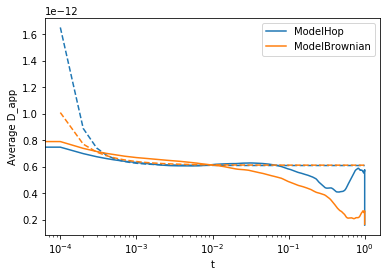

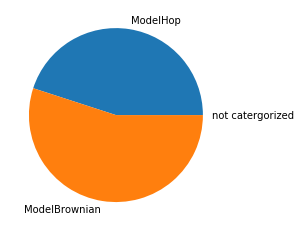

In [35]:
tracks.adc_summary(plot_dapp = True, plot_pie_chart=True, interpolation=True)

Now that analysis is done we can also retreive all tracks that fit a certain diffusion category best:

/home/iscat/Desktop/iSCAT_tracking/iscat_lib/analysis/models.py:20: RuntimeWarning: divide by zero encountered in true_divide
  return D + delta**2 / (2*t*(1-2*self.R*self.dt/t))
/home/iscat/Desktop/iSCAT_tracking/iscat_lib/analysis/models.py:20: RuntimeWarning: invalid value encountered in multiply
  return D + delta**2 / (2*t*(1-2*self.R*self.dt/t))


{'sectors': {'ModelBrownian': 1.0, 'not catergorized': 0.0},
 'average_params': {'ModelBrownian': array([6.10893112e-13, 7.27674758e-09])},
 'average_msd': {'ModelBrownian': array([2.63574497e-16, 5.26090057e-16, 7.87142054e-16, ...,
         1.03046943e-12, 1.03020808e-12, 6.60623957e-13])},
 'average_dapp': {'ModelBrownian': array([9.88339533e-13, 7.89068059e-13, 7.37878813e-13, ...,
         2.57703272e-13, 2.57612140e-13, 1.65178017e-13])}}

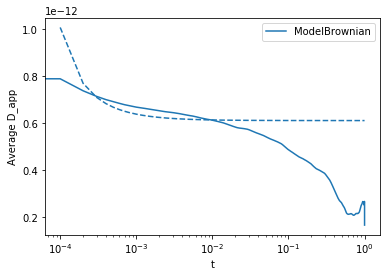

In [38]:
tracks_brownian = tracks.get_sublist(method="adc", model=ModelBrownian)
tracks_brownian.adc_summary(plot_dapp=True, interpolation=True)

As mentioned before, we can retreive the analysis results for any track, at any time:

In [39]:
tracks_brownian.get_track(5).get_adc_analysis_results()

{'Dapp': array([7.46403698e-13, 6.00164355e-13, 5.63422184e-13, ...,
        3.32233898e-13, 3.32910881e-13, 3.32914125e-13]),
 'fit_indices': [0, 1, 3, 6, 11, 19, 31, 50, 80, 128, 204, 324],
 'fit_results': {'ModelBrownian': {'params': array([4.94706265e-13, 5.86807492e-09]),
   'errors': array([3.30130327e-15, 7.16723406e-11]),
   'bic': -62.18667866075932,
   'rel_likelihood': 1.0},
  'ModelConfined': {'params': array([3.12367014e-15, 1.25754776e-08, 7.96826973e-15]),
   'errors': array([0.00000000e+00, 8.77333588e-09, 6.25658067e+02]),
   'bic': -54.42481879708853,
   'rel_likelihood': 0.020631630248321972},
  'ModelHop': {'params': array([5.09893099e-13, 4.91443808e-11, 2.07647073e-09, 6.74430381e-06]),
   'errors': array([9.32247198e-15, 5.63145053e-09, 2.11032696e-09, 3.96613919e-04]),
   'bic': -60.911199761524045,
   'rel_likelihood': 0.5284857434049421}},
 'best_model': 'ModelBrownian'}

We can also plot them:

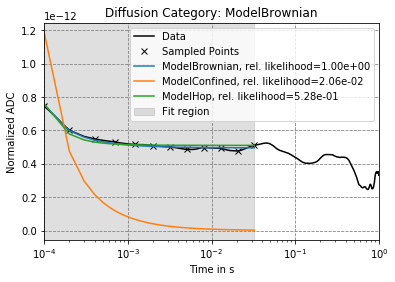

In [40]:
tracks_brownian.get_track(5).plot_adc_analysis_results()